In [277]:
import rosbag
import rospy


import pandas as pd

import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [278]:
#read bag:

bag_name = '/home/nico/rosbags/BA/2022-07-21-11-46-32.bag'

bag = rosbag.Bag(bag_name)

filename = bag_name.split(sep='/')[-1]

date_time = filename.split(sep='.')[0]

In [279]:
palette = sns.color_palette('pastel')
sns.set_style('whitegrid') # darkgrid, whitegrid, dark, white and
plt.rc('lines', linewidth=3)     # linewidth
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('font', size=18)          # controls default text sizes

In [280]:
def cut_list(list, time):
    retList = []
    for i, t in enumerate(time):
        if t < 40.0:
            retList.append(list[i])
        else:
            break
    return retList

def cut_list_sec(list, time, seconds):
    retList = []
    for i, t in enumerate(time):
        if t < seconds:
            retList.append(list[i])
        else:
            break
    return retList


# Odometry

In [281]:
stamp = []
position = []
velocity = []
orientation = []
angular_velocity = []

for topic, msg, t in bag.read_messages('/geranos/visual_servoing/transformed_odometry'):
    stamp.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    position.append([msg.pose.pose.position.x , msg.pose.pose.position.y, msg.pose.pose.position.z])
    velocity.append([msg.twist.twist.linear.x , msg.twist.twist.linear.y, msg.twist.twist.linear.z])
    orientation.append(R.from_quat([msg.pose.pose.orientation.x, msg.pose.pose.orientation.y,
                                    msg.pose.pose.orientation.z, msg.pose.pose.orientation.w]).as_euler('xyz', degrees=True))
    angular_velocity.append([msg.twist.twist.angular.x, msg.twist.twist.angular.y, msg.twist.twist.angular.z])
time = [s-stamp[0] for s in stamp]


position = cut_list(position, time)
velocity = cut_list(velocity, time)
orientation = cut_list(orientation, time)
angular_velocity = cut_list(angular_velocity, time)
time = cut_list(time, time)

position = np.array(position)
velocity = np.array(velocity)
orientation = np.array(orientation)
angular_velocity = np.array(angular_velocity)

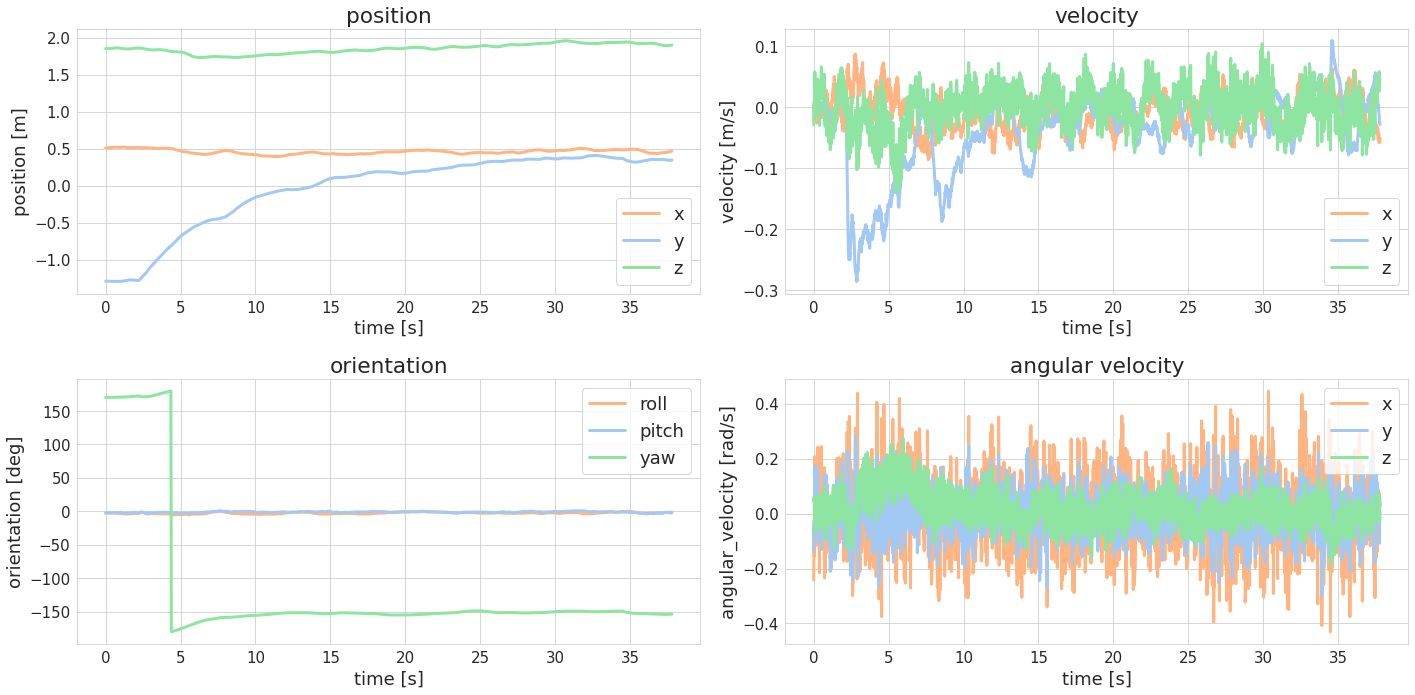

In [282]:
#Visualization:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20, 10), tight_layout=True)

ax[0][0].set(title='position', xlabel='time [s]', ylabel='position [m]')
ax[0][0].plot(time,position[:,0],color = palette[1],label = 'x')
ax[0][0].plot(time,position[:,1],color = palette[0],label = 'y')
ax[0][0].plot(time,position[:,2],color = palette[2],label = 'z')
ax[0][0].legend()

ax[0][1].set(title='velocity', xlabel='time [s]', ylabel='velocity [m/s]')
ax[0][1].plot(time,velocity[:,0],color = palette[1],label = 'x')
ax[0][1].plot(time,velocity[:,1],color = palette[0],label = 'y')
ax[0][1].plot(time,velocity[:,2],color = palette[2],label = 'z')
ax[0][1].legend()

ax[1][0].set(title='orientation', xlabel='time [s]', ylabel='orientation [deg]')
ax[1][0].plot(time,orientation[:,0],color = palette[1],label = 'roll')
ax[1][0].plot(time,orientation[:,1],color = palette[0],label = 'pitch')
ax[1][0].plot(time,orientation[:,2],color = palette[2],label = 'yaw')
ax[1][0].legend()

ax[1][1].set(title='angular velocity', xlabel='time [s]', ylabel='angular_velocity [rad/s]')
ax[1][1].plot(time,angular_velocity[:,0],color = palette[1],label = 'x')
ax[1][1].plot(time,angular_velocity[:,1],color = palette[0],label = 'y')
ax[1][1].plot(time,angular_velocity[:,2],color = palette[2],label = 'z')
ax[1][1].legend()

plt.savefig('/home/nico/Pictures/odometry_test'+ date_time +'.pdf')

# pose_est vs ground truth

In [283]:
stamp_estimate = []
stamp_gt = []
position_estimate = []
position_gt = []


for topic, msg, t in bag.read_messages('/geranos/visual_servoing/estimated_pole_position'):
    stamp_estimate.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    position_estimate.append([msg.point.x , msg.point.y, msg.point.z])

time_estimate = [s-stamp_estimate[0] for s in stamp_estimate]
position_estimate = cut_list(position_estimate, time_estimate)
time_estimate = cut_list(time_estimate, time_estimate)

position_estimate = np.array(position_estimate)

for topic, msg, t in bag.read_messages('/geranos/geranos_pole_white/vrpn_client/estimated_transform'):
    stamp_gt.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    position_gt.append([msg.transform.translation.x , msg.transform.translation.y, msg.transform.translation.z])

time_gt = [s-stamp_gt[0] for s in stamp_gt]
position_gt = cut_list(position_gt, time_gt)
time_gt = cut_list(time_gt, time_gt)

position_gt = np.array(position_gt)

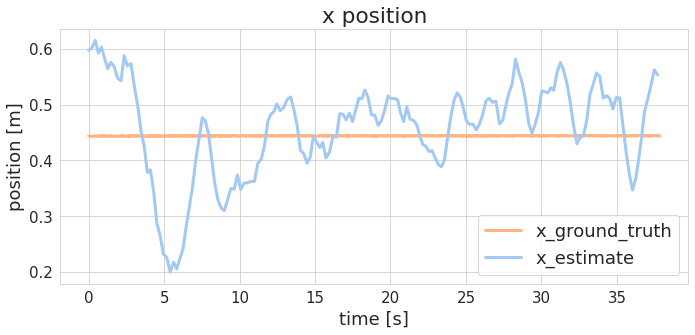

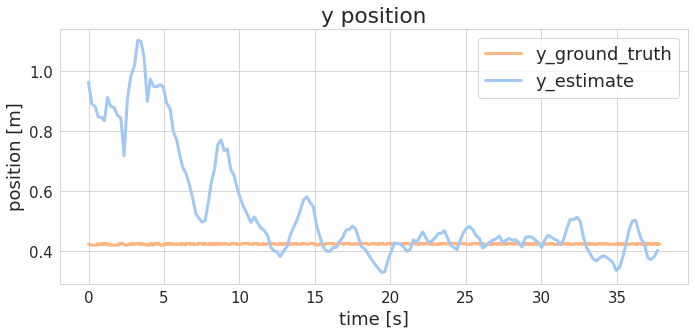

In [284]:
#Visualization
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='x position', xlabel='time [s]', ylabel='position [m]')
ax.plot(time_gt,position_gt[:,0],color = palette[1],label = 'x_ground_truth')
ax.plot(time_estimate,position_estimate[:,0],color = palette[0],label = 'x_estimate')
ax.legend()

plt.savefig('/home/nico/Pictures/pose_est_test_x_'+date_time+'.pdf')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='y position', xlabel='time [s]', ylabel='position [m]')
ax.plot(time_gt,position_gt[:,1],color = palette[1],label = 'y_ground_truth')
ax.plot(time_estimate,position_estimate[:,1],color = palette[0],label = 'y_estimate')
ax.legend()

plt.savefig('/home/nico/Pictures/pose_est_test_y_'+date_time+'.pdf')

# Servoing

In [285]:
stamp = []
stamp_estimate = []
stamp_gt = []
position = []
position_estimate = []
position_gt = []

for topic, msg, t in bag.read_messages('/geranos/visual_servoing/transformed_odometry'):
    stamp.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    position.append([msg.pose.pose.position.x , msg.pose.pose.position.y, msg.pose.pose.position.z])

time = [s-stamp[0] for s in stamp]
position = cut_list(position, time)
time = cut_list(time, time)

position = np.array(position)

for topic, msg, t in bag.read_messages('/geranos/visual_servoing/estimated_pole_position'):
    stamp_estimate.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    position_estimate.append([msg.point.x , msg.point.y, msg.point.z])

time_estimate = [s-stamp_estimate[0] for s in stamp_estimate]
position_estimate = cut_list(position_estimate, time_estimate)
time_estimate = cut_list(time_estimate, time_estimate)

position_estimate = np.array(position_estimate)

for topic, msg, t in bag.read_messages('/geranos/geranos_pole_white/vrpn_client/estimated_transform'):
    stamp_gt.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    position_gt.append([msg.transform.translation.x , msg.transform.translation.y, msg.transform.translation.z])

time_gt = [s-stamp_gt[0] for s in stamp_gt]
position_gt = cut_list(position_gt, time_gt)
time_gt = cut_list(time_gt, time_gt)

position_gt = np.array(position_gt)


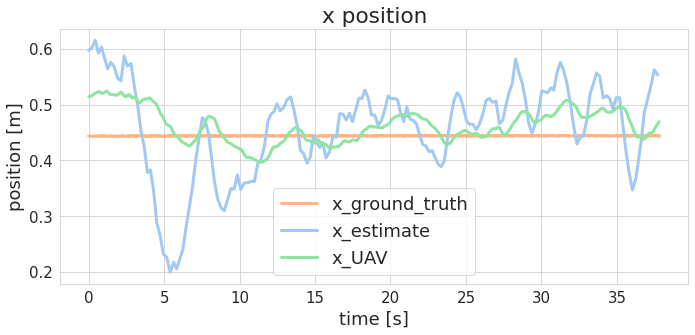

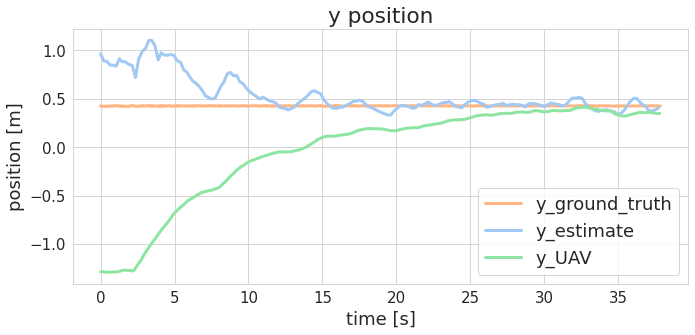

In [286]:
#Visualization
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='x position', xlabel='time [s]', ylabel='position [m]')
ax.plot(time_gt,position_gt[:,0],color = palette[1],label = 'x_ground_truth')
ax.plot(time_estimate,position_estimate[:,0],color = palette[0],label = 'x_estimate')
ax.plot(time,position[:,0],color = palette[2], label = 'x_UAV')
ax.legend()

plt.savefig('/home/nico/Pictures/servoing_test_x_'+date_time+'.pdf')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='y position', xlabel='time [s]', ylabel='position [m]')
ax.plot(time_gt,position_gt[:,1],color = palette[1],label = 'y_ground_truth')
ax.plot(time_estimate,position_estimate[:,1],color = palette[0],label = 'y_estimate')
ax.plot(time,position[:,1],color = palette[2], label = 'y_UAV')
ax.legend()

plt.savefig('/home/nico/Pictures/servoing_test_y_'+date_time+'.pdf')

# Yaw Servoing

In [287]:
stamp_yaw = []
yaw_des = []
yaw = []
yaw_error = []

for topic, msg, t in bag.read_messages('/geranos/visual_servoing/yaw'):
    stamp_yaw.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
    yaw_des.append([msg.point.x * 180 / np.pi])
    yaw.append([msg.point.y * 180 / np.pi])
    yaw_error.append([msg.point.z * 180 / np.pi])

time_yaw = [s-stamp_yaw[0] for s in stamp_yaw]
yaw_des = cut_list_sec(yaw_des, time_yaw, 20.0)
yaw = cut_list_sec(yaw, time_yaw, 20.0)
yaw_error = cut_list_sec(yaw_error, time_yaw, 20.0)
time_yaw = cut_list_sec(time_yaw, time_yaw, 20.0)

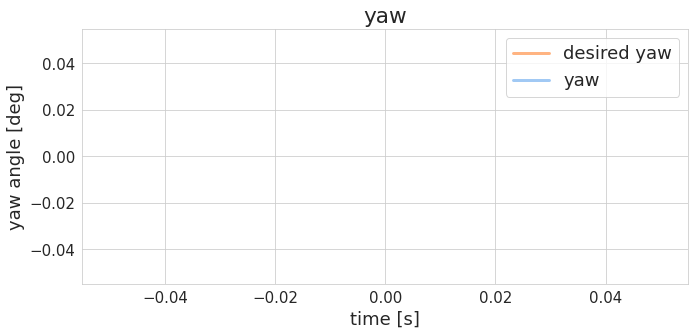

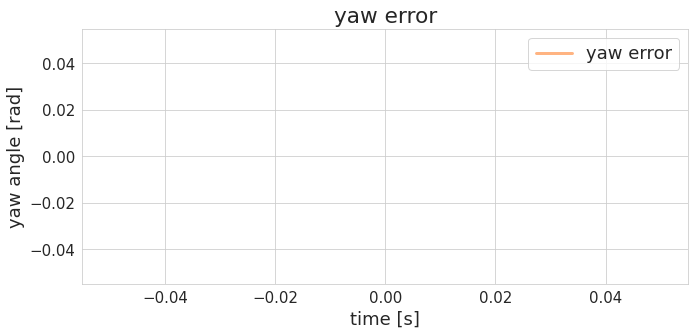

In [288]:
#Visualization
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='yaw', xlabel='time [s]', ylabel='yaw angle [deg]')
ax.plot(time_yaw,yaw_des,color = palette[1],label = 'desired yaw')
ax.plot(time_yaw,yaw,color = palette[0],label = 'yaw')
ax.legend()

plt.savefig('/home/nico/Pictures/yaw_test_'+date_time+'.pdf')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='yaw error', xlabel='time [s]', ylabel='yaw angle [rad]')
ax.plot(time_yaw,yaw_error,color = palette[1],label =  'yaw error')
ax.legend()

plt.savefig('/home/nico/Pictures/yaw_test_error_'+date_time+'.pdf')

In [289]:
bag.close()